

```
# author: puru panta (purupanta@uky.edu)
# date: 11/30/2024
# filename: PredictMLDL_Separate
```



**STEP1: Install and Import libraries required**

In [ ]:
import json
import time

In [ ]:
# Mounting google drive if it is already not mounted
def LoadGoogleDrive(googleDriveDir):
  # Link Google Drive
  import os
  # Check if Google Drive is already mounted
  if not os.path.exists(googleDriveDir + "/MyDrive"):
      print("Mounting Google Drive...")
      from google.colab import drive
      drive.mount(googleDriveDir)
  else:
      print("Google Drive is already mounted!")

# Loading the AppConfig file
def LoadAppConfig(json_file_path):
  # Load JSON file into a Python dictionary
  with open(json_file_path, "r") as json_file:
      config_data = json.load(json_file)

  # Print loaded JSON data
  print("AppConfig JSON File Loaded Successfully!")
  # print(config_data)
  return config_data

# Loading the AppLib file
def AppLib_reload_script(script_path):
  # Load AppLib.py
  with open(script_path, 'r') as file:
      script_code = file.read()
      exec(script_code, globals())

**STEP2: Load goofle-drive, libraries, config file and application library file**

In [ ]:
# Mount the google drive
googleDriveFolder = "/content/drive"
LoadGoogleDrive(googleDriveFolder)

# Load the AppConfig json file
json_file_path = googleDriveFolder + "/MyDrive/Colab Notebooks/HINTS6Finale/AppConfig.json"
config_data = LoadAppConfig(json_file_path)

# Load AppLib
lib_script_path = config_data["project_location"] + config_data["app_lib_path"] + config_data["app_lib_filename"]
print(f"Loading AppLib from: {lib_script_path}")
AppLib_reload_script(lib_script_path)


Mounting Google Drive...
Mounted at /content/drive
AppConfig JSON File Loaded Successfully!
Loading AppLib from: drive/MyDrive/Colab Notebooks/HINTS6Finale/lib/AppLib.py


In [ ]:
requirements_path = config_data["project_location"] + config_data["requirements_file_name"]
AppLib.LoadRequirements(requirements_path)

Installing missing packages: ['tf-keras', 'scikit-learn', 'imbalanced-learn', 'xlsxwriter']
Installation completed successfully!
Please restart the runtime for changes to take effect.


**STEP3: Load the original data with filtered columns**

In [ ]:
# Define the output file path
ip_file_path = config_data["project_location"] + config_data["op_data_dir"] + config_data["op_file_name_cleaned"];
ip_sheet_name = config_data["op_file_sheet_name_cleaned"]
ip_load_data_cols = config_data["study_cols"]["target_cols"] + config_data["study_cols"]["predictor_cols"] + config_data["study_cols"]["predictor_cols0"]

# Loading cleaded excel data
df_rowColFilteredCleaned = AppLib.load_data(ip_file_path, ip_sheet_name, ip_load_data_cols)


Data Size: 87750, Data Shape: (4875, 18), (Flag: Loaded, original data)


In [ ]:
df = df_rowColFilteredCleaned.copy()

**STEP4: Data Scale AND adding a data-sheet**

In [ ]:
predictors = config_data["study_cols"]["predictor_cols"] + config_data["study_cols"]["predictor_cols0"]
target = config_data["study_cols"]["target_cols"]
X, y = AppLib.define_target_predictors(df, predictors, target)

Unique values in the target variable after filtering: [1 0]


**STEP5: Standard Scaler**

In [ ]:
## Standardize scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**STEP6: SMOTE Data**

In [ ]:
# 'smote_data'
# SMOTE is used to handle class imbalance during the training process to help the model learn better representations for the minority class. It artificially generates new samples for the minority class by interpolating between existing samples.
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

**STEP7: Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# Reshape the target variable if necessary
y_train = y_train.to_numpy().ravel()  # Convert to 1D array
y_test = y_test.to_numpy().ravel()    # Convert to 1D array (if needed)


**STEP8: Prediction Starts**

**1. Logistic Regression (LR):**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train/Test assignments
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()
X_test_lr = X_test.copy()
y_test_lr = y_test.copy()

Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.71      0.75       886
     Class 1       0.73      0.82      0.77       882

    accuracy                           0.76      1768
   macro avg       0.77      0.76      0.76      1768
weighted avg       0.77      0.76      0.76      1768

AUC-ROC: 0.83


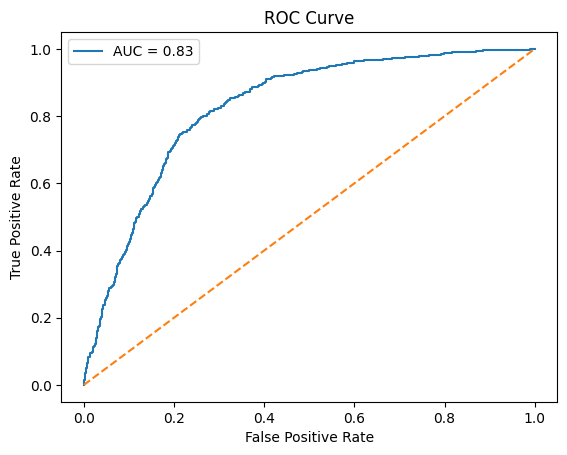

Feature Importance:
                           Feature  Coefficient
0                             Age     0.818293
2            MedConditions_HighBP     0.524669
11                 FreqGoProvider     0.432143
3                   GeneralHealth     0.315144
5       MedConditions_LungDisease     0.190314
6                            PHQ4     0.128313
4          MedConditions_Diabetes     0.110340
15                      smokeStat     0.097386
12       MedConditions_Depression     0.092814
13              AverageSleepNight     0.014177
8   WeeklyMinutesModerateExercise     0.012292
16                           Deaf     0.000558
9                   EverHadCancer    -0.074186
14                            BMI    -0.075340
10             AverageTimeSitting    -0.098981
7                AvgDrinksPerWeek    -0.125040
1                     BirthGender    -0.319502
Total execution time: 0.78 seconds


In [ ]:
# Start timing
start_time = time.time()

model_lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
model_lr.fit(X_train_lr, y_train_lr)

# Predictions and performance metrics
y_pred_lr = model_lr.predict(X_test_lr)
y_prob_lr = model_lr.predict_proba(X_test_lr)[:, 1]

# Accuracy
accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)
print(f"Accuracy: {accuracy_lr:.2f}")

# Classification report: Get unique classes in y_test_lr to dynamically handle target names
unique_classes_lr = np.unique(y_test_lr)
target_names = ['Class ' + str(int(cls)) for cls in unique_classes_lr]

# Generate classification report based on actual classes in y_test_lr
report = classification_report(y_test_lr, y_pred_lr, target_names=target_names)
print("Classification Report:\n", report)

# AUC-ROC
auc_roc = roc_auc_score(y_test_lr, y_prob_lr)
print(f"AUC-ROC: {auc_roc:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_lr, y_prob_lr)
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.show()

# Feature Importance
coefficients_lr = pd.DataFrame({'Feature': predictors, 'Coefficient': model_lr.coef_[0]})
coefficients_lr = coefficients_lr.sort_values(by='Coefficient', ascending=False)
print("Feature Importance:\n", coefficients_lr)

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")


**2: Random Forest (RF):**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Train/Test assignments
X_train_rf = X_train.copy()
y_train_rf = y_train.copy()
X_test_rf = X_test.copy()
y_test_rf = y_test.copy()

Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.96      0.95       886
     Class 1       0.96      0.95      0.95       882

    accuracy                           0.95      1768
   macro avg       0.95      0.95      0.95      1768
weighted avg       0.95      0.95      0.95      1768

AUC-ROC: 0.99


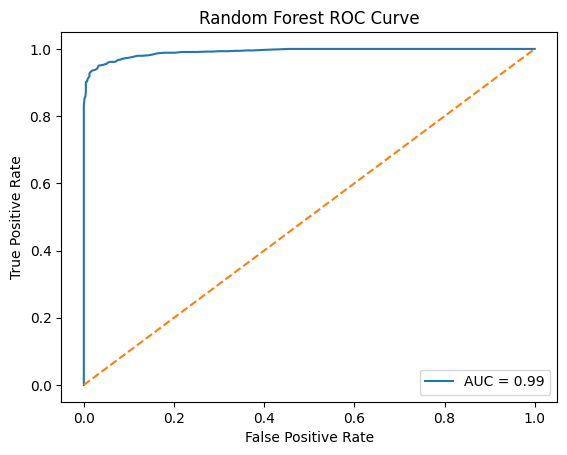

Feature Importances:
                           Feature  Importance
2            MedConditions_HighBP    0.150289
0                             Age    0.135349
11                 FreqGoProvider    0.114771
3                   GeneralHealth    0.107825
13              AverageSleepNight    0.060788
6                            PHQ4    0.059587
10             AverageTimeSitting    0.057710
15                      smokeStat    0.057563
14                            BMI    0.055065
8   WeeklyMinutesModerateExercise    0.050150
7                AvgDrinksPerWeek    0.040048
1                     BirthGender    0.030339
4          MedConditions_Diabetes    0.025742
5       MedConditions_LungDisease    0.018220
12       MedConditions_Depression    0.016160
9                   EverHadCancer    0.011424
16                           Deaf    0.008969
Total execution time: 3.45 seconds


In [ ]:
# Start timing
start_time = time.time()

# Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_rf.fit(X_train_rf, y_train_rf)

# Predictions and performance metrics
y_pred_rf = model_rf.predict(X_test_rf)
y_prob_rf = model_rf.predict_proba(X_test_rf)[:, 1]

# Accuracy
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.2f}")

# Classification report
unique_classes_rf = np.unique(y_test_rf)
target_names = ['Class ' + str(int(cls)) for cls in unique_classes_rf]
report_rf = classification_report(y_test_rf, y_pred_rf, target_names=target_names)
print("Classification Report:\n", report_rf)

# AUC-ROC
auc_roc_rf = roc_auc_score(y_test_rf, y_prob_rf)
print(f"AUC-ROC: {auc_roc_rf:.2f}")

# ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {auc_roc_rf:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()

# Step 7: Feature Importance
feature_importances = pd.DataFrame({'Feature': predictors, 'Importance': model_rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", feature_importances)

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

**3. Support Vector Machine (SVM):**

In [ ]:
from sklearn.svm import SVC

# Train/Test assignments
X_train_svm = X_train.copy()
y_train_svm = y_train.copy()
X_test_svm = X_test.copy()
y_test_svm = y_test.copy()

Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.81      0.66      0.73       886
     Class 1       0.71      0.84      0.77       882

    accuracy                           0.75      1768
   macro avg       0.76      0.75      0.75      1768
weighted avg       0.76      0.75      0.75      1768

AUC-ROC: 0.82


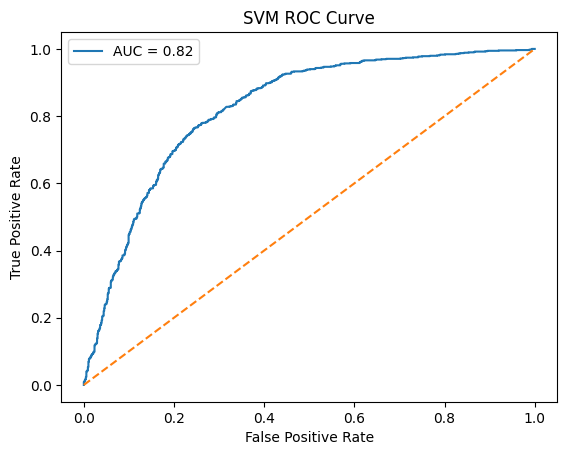

Total execution time: 19.05 seconds


In [ ]:
# Start timing
start_time = time.time()

# SVM model
svm_model = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_svm, y_train_svm)

# Predictions and performance metrics
svm_y_pred = svm_model.predict(X_test_svm)
svm_y_prob = svm_model.predict_proba(X_test_svm)[:, 1]

# Accuracy
svm_accuracy = accuracy_score(y_test_svm, svm_y_pred)
print(f"Accuracy: {svm_accuracy:.2f}")

# Classification report
svm_unique_classes = np.unique(y_test_svm)
svm_target_names = ['Class ' + str(int(cls)) for cls in svm_unique_classes]
svm_report = classification_report(y_test_svm, svm_y_pred, target_names=svm_target_names)
print("Classification Report:\n", svm_report)

# AUC-ROC
svm_auc_roc = roc_auc_score(y_test_svm, svm_y_prob)
print(f"AUC-ROC: {svm_auc_roc:.2f}")

# ROC Curve
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test_svm, svm_y_prob)
plt.plot(svm_fpr, svm_tpr, label=f'AUC = {svm_auc_roc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend()
plt.show()

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

**4. K Nearest Neighbor(KNN):**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Train/Test assignments
X_train_knn = X_train.copy()
y_train_knn = y_train.copy()
X_test_knn = X_test.copy()
y_test_knn = y_test.copy()

Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      0.72      0.83       886
     Class 1       0.78      0.99      0.87       882

    accuracy                           0.86      1768
   macro avg       0.89      0.86      0.85      1768
weighted avg       0.89      0.86      0.85      1768

AUC-ROC: 0.94


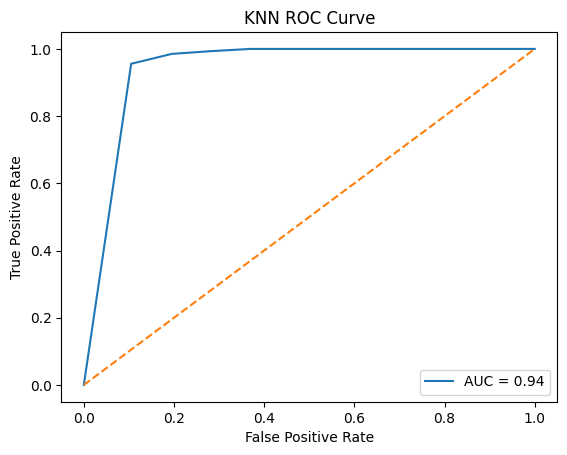

Total execution time: 3.31 seconds


In [ ]:
# Start timing
start_time = time.time()

# K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')  # You can tune n_neighbors for optimal results
knn_model.fit(X_train_knn, y_train_knn)

# Predictions and performance metrics
y_pred_knn = knn_model.predict(X_test_knn)
y_prob_knn = knn_model.predict_proba(X_test_knn)[:, 1]

# Accuracy
accuracy_knn = accuracy_score(y_test_knn, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.2f}")

# Classification report
unique_classes_knn = np.unique(y_test_knn)
target_names_knn = ['Class ' + str(int(cls)) for cls in unique_classes_knn]
report_knn = classification_report(y_test_knn, y_pred_knn, target_names=target_names_knn)
print("Classification Report:\n", report_knn)

# AUC-ROC
auc_roc_knn = roc_auc_score(y_test_knn, y_prob_knn)
print(f"AUC-ROC: {auc_roc_knn:.2f}")

# ROC Curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test_knn, y_prob_knn)
plt.plot(fpr_knn, tpr_knn, label=f'AUC = {auc_roc_knn:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend()
plt.show()

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

**5. GRADIENT BOOSTING MODEL (GBM):**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# Train/Test assignments
X_train_gbm = X_train.copy()
y_train_gbm = y_train.copy()
X_test_gbm = X_test.copy()
y_test_gbm = y_test.copy()

Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.96      0.94       886
     Class 1       0.96      0.91      0.93       882

    accuracy                           0.93      1768
   macro avg       0.94      0.93      0.93      1768
weighted avg       0.94      0.93      0.93      1768

AUC-ROC: 0.98


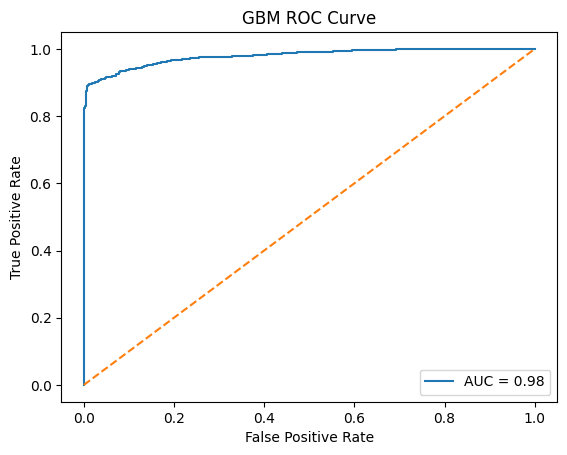

Feature Importances:
                           Feature  Importance
2            MedConditions_HighBP    0.298154
11                 FreqGoProvider    0.184827
3                   GeneralHealth    0.142406
0                             Age    0.083685
15                      smokeStat    0.075134
13              AverageSleepNight    0.068621
6                            PHQ4    0.039982
1                     BirthGender    0.035941
7                AvgDrinksPerWeek    0.020874
10             AverageTimeSitting    0.011970
8   WeeklyMinutesModerateExercise    0.009781
4          MedConditions_Diabetes    0.009568
5       MedConditions_LungDisease    0.009526
12       MedConditions_Depression    0.005979
14                            BMI    0.002795
16                           Deaf    0.000429
9                   EverHadCancer    0.000327
Total execution time: 2.32 seconds


In [ ]:
# Start timing
start_time = time.time()

# Gradient Boosting model
model_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gbm.fit(X_train_gbm, y_train_gbm)

# Predictions and performance metrics
y_pred_gbm = model_gbm.predict(X_test_gbm)
y_prob_gbm = model_gbm.predict_proba(X_test_gbm)[:, 1]

# Accuracy
accuracy_gbm = accuracy_score(y_test_gbm, y_pred_gbm)
print(f"Accuracy: {accuracy_gbm:.2f}")

# Classification report
unique_classes_gbm = np.unique(y_test_gbm)
target_names_gbm = ['Class ' + str(int(cls)) for cls in unique_classes_gbm]
report_gbm = classification_report(y_test_gbm, y_pred_gbm, target_names=target_names_gbm)
print("Classification Report:\n", report_gbm)

# AUC-ROC
auc_roc_gbm = roc_auc_score(y_test_gbm, y_prob_gbm)
print(f"AUC-ROC: {auc_roc_gbm:.2f}")

# ROC Curve
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test_gbm, y_prob_gbm)
plt.plot(fpr_gbm, tpr_gbm, label=f'AUC = {auc_roc_gbm:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GBM ROC Curve')
plt.legend()
plt.show()

# Feature Importances
feature_importances_gbm = pd.DataFrame({'Feature': predictors, 'Importance': model_gbm.feature_importances_})
feature_importances_gbm = feature_importances_gbm.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", feature_importances_gbm)

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

**6. XGBOOST:**

In [ ]:
from xgboost import XGBClassifier
# Train/Test assignments
X_train_xgb = X_train.copy()
y_train_xgb = y_train.copy()
X_test_xgb = X_test.copy()
y_test_xgb = y_test.copy()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:49:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.95      0.93       886
     Class 1       0.95      0.90      0.92       882

    accuracy                           0.92      1768
   macro avg       0.92      0.92      0.92      1768
weighted avg       0.92      0.92      0.92      1768

AUC-ROC: 0.98


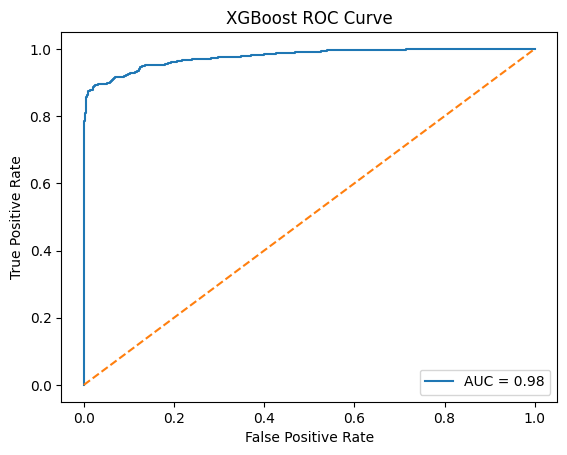

Feature Importances:
                           Feature  Importance
2            MedConditions_HighBP    0.294125
15                      smokeStat    0.091195
3                   GeneralHealth    0.082696
1                     BirthGender    0.076368
11                 FreqGoProvider    0.075464
0                             Age    0.058265
13              AverageSleepNight    0.048707
5       MedConditions_LungDisease    0.048107
6                            PHQ4    0.044831
12       MedConditions_Depression    0.042896
7                AvgDrinksPerWeek    0.037649
10             AverageTimeSitting    0.025491
4          MedConditions_Diabetes    0.023792
8   WeeklyMinutesModerateExercise    0.020930
14                            BMI    0.011922
9                   EverHadCancer    0.009371
16                           Deaf    0.008189
Total execution time: 0.40 seconds


In [ ]:
# Start timing
start_time = time.time()

# Step 5: XGBoost model
model_xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=True, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train_xgb, y_train_xgb)

# Step 6: Predictions and performance metrics
y_pred_xgb = model_xgb.predict(X_test_xgb)
y_prob_xgb = model_xgb.predict_proba(X_test_xgb)[:, 1]

# Accuracy
accuracy_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
print(f"Accuracy: {accuracy_xgb:.2f}")

# Classification report
unique_classes_xgb = np.unique(y_test_xgb)
target_names_xgb = ['Class ' + str(int(cls)) for cls in unique_classes_xgb]
report_xgb = classification_report(y_test_xgb, y_pred_xgb, target_names=target_names_xgb)
print("Classification Report:\n", report_xgb)

# AUC-ROC
auc_roc_xgb = roc_auc_score(y_test_xgb, y_prob_xgb)
print(f"AUC-ROC: {auc_roc_xgb:.2f}")

# ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test_xgb, y_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC = {auc_roc_xgb:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend()
plt.show()

# Feature Importance
feature_importances_xgb = pd.DataFrame({'Feature': predictors, 'Importance': model_xgb.feature_importances_})
feature_importances_xgb = feature_importances_xgb.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", feature_importances_xgb)

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")


**7. Artificial Neural Network (ANN):**

In [ ]:
!pip install --upgrade tensorflow
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Train/Test assignments
X_train_ann = X_train.copy()
y_train_ann = y_train.copy()
X_test_ann = X_test.copy()
y_test_ann = y_test.copy()

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6971 - loss: 0.5937 - val_accuracy: 0.7588 - val_loss: 0.4808
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7764 - loss: 0.4662 - val_accuracy: 0.7793 - val_loss: 0.4581
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8078 - loss: 0.4377 - val_accuracy: 0.7956 - val_loss: 0.4349
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8098 - loss: 0.4223 - val_accuracy: 0.8006 - val_loss: 0.4134
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8322 - loss: 0.3895 - val_accuracy: 0.8296 - val_loss: 0.3966
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8435 - loss: 0.3702 - val_accuracy: 0.8345 - val_loss: 0.3814
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8543 - loss: 0.3510 - val_accuracy: 0.8380 - val_loss: 0.3632
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8753 - loss: 0.3070 - val_accuracy: 0

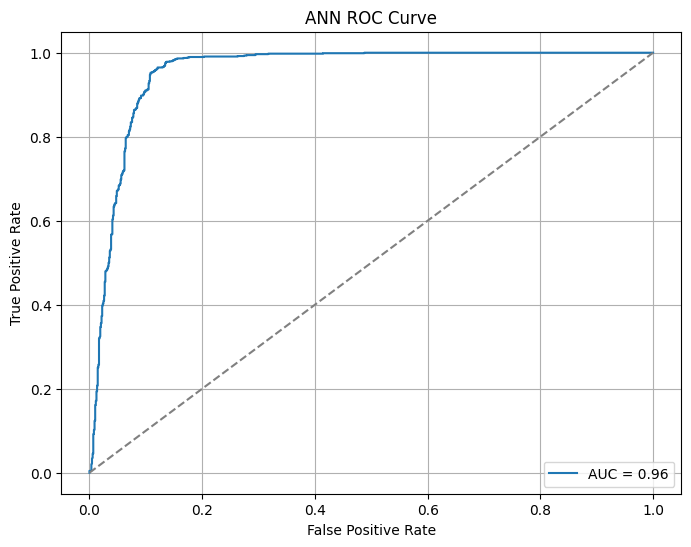

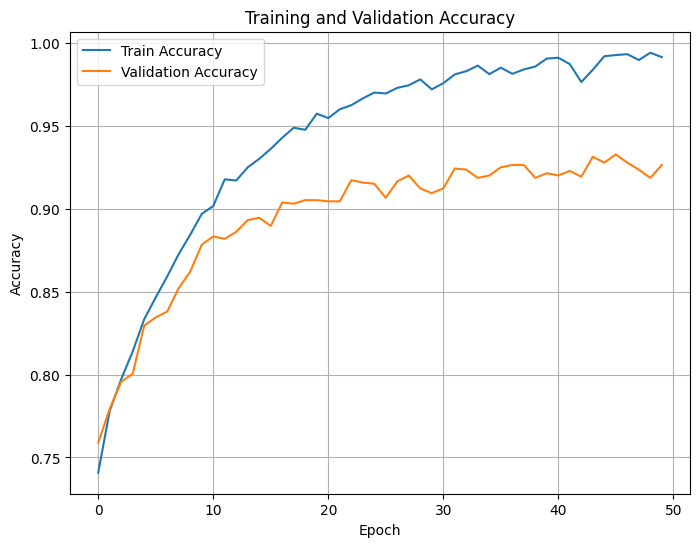

Total execution time: 45.38 seconds


In [ ]:
# Start timing
start_time = time.time()

# Step 5: Define the ANN model using an explicit Input layer
model_ann = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(64, activation='relu'),      # First hidden layer
    Dense(32, activation='relu'),      # Second hidden layer
    Dense(16, activation='relu'),      # Third hidden layer
    Dense(1, activation='sigmoid')     # Output layer (binary classification)
])

# Compile the model
model_ann.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Step 6: Train the model
history_ann = model_ann.fit(
    X_train_ann, y_train_ann,
    epochs=50, batch_size=32,
    validation_split=0.2, verbose=1
)


# Step 7: Predictions and performance metrics
# Predict probabilities
y_prob_ann = model_ann.predict(X_test_ann).ravel()

# Convert probabilities to binary predictions
y_pred_ann = (y_prob_ann > 0.5).astype(int)

# Accuracy
accuracy_ann = accuracy_score(y_test_ann, y_pred_ann)
print(f"Accuracy: {accuracy_ann:.2f}")

# Classification report
unique_classes_ann = np.unique(y_test_ann)
target_names_ann = [f'Class {int(cls)}' for cls in unique_classes_ann]
report_ann = classification_report(y_test_ann, y_pred_ann, target_names=target_names_ann)
print("Classification Report:\n", report_ann)

# AUC-ROC
auc_roc_ann = roc_auc_score(y_test_ann, y_prob_ann)
print(f"AUC-ROC: {auc_roc_ann:.2f}")

# ROC Curve
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test_ann, y_prob_ann)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, label=f'AUC = {auc_roc_ann:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Plot Training History
plt.figure(figsize=(8, 6))
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")


**8. Recurrent Neural Network (RNN):**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Train/Test assignments
X_train_rnn = X_train.copy()
y_train_rnn = y_train.copy()
X_test_rnn = X_test.copy()
y_test_rnn = y_test.copy()

In [ ]:
# Reshaping needed for RNN
X_train_rnn = X_train_rnn.reshape(X_train_rnn.shape[0], 1, X_train_rnn.shape[1])
X_test_rnn = X_test_rnn.reshape(X_test_rnn.shape[0], 1, X_test_rnn.shape[1])


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6488 - loss: 0.6161 - val_accuracy: 0.7751 - val_loss: 0.4883
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7658 - loss: 0.5092 - val_accuracy: 0.7900 - val_loss: 0.4677
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7751 - loss: 0.4872 - val_accuracy: 0.8027 - val_loss: 0.4560
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7972 - loss: 0.4648 - val_accuracy: 0.8069 - val_loss: 0.4477
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7889 - loss: 0.4604 - val_accuracy: 0.8055 - val_loss: 0.4436
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8016 - loss: 0.4417 - val_accuracy: 0.8048 - val_loss: 0.4393
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8028 - loss: 0.4330 - val_accuracy: 0.8091 - val_loss: 0.4254
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7951 - loss: 0.4398 - val_accuracy: 0.

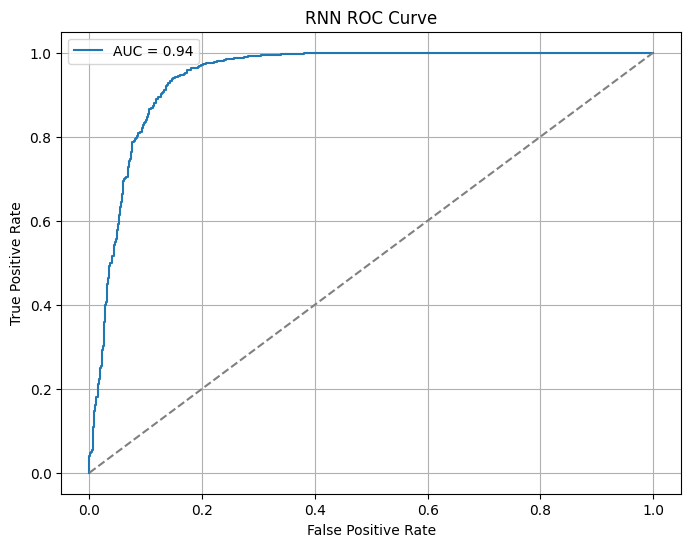

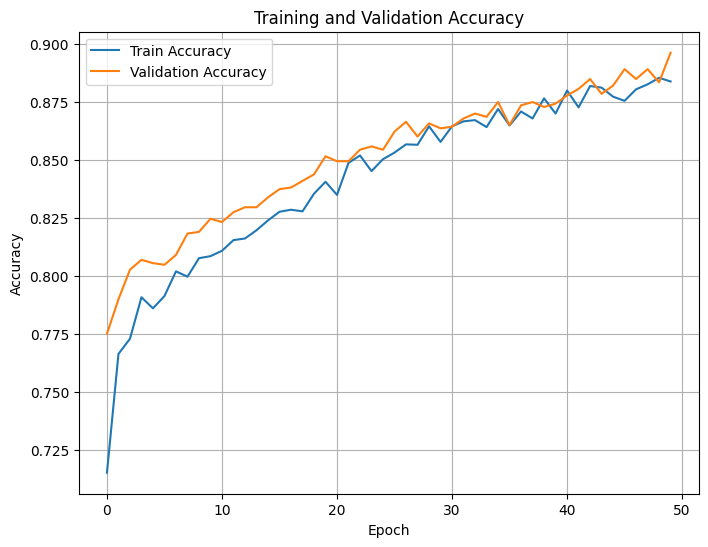

Total execution time: 79.83 seconds


In [ ]:
# Start timing
start_time = time.time()

# Step 5: Define the RNN model
model_rnn = Sequential([
    Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),  # Explicit Input layer
    SimpleRNN(64, activation='relu', return_sequences=True),    # First RNN layer
    Dropout(0.2),
    SimpleRNN(32, activation='relu'),                           # Second RNN layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')                              # Output layer for binary classification
])

# Compile the model
model_rnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Step 6: Train the model
history_rnn = model_rnn.fit(
    X_train_rnn, y_train_rnn,
    epochs=50, batch_size=32,
    validation_split=0.2, verbose=1
)

# Step 7: Predictions and performance metrics
y_prob_rnn = model_rnn.predict(X_test_rnn).ravel()
y_pred_rnn = (y_prob_rnn > 0.5).astype(int)

# Accuracy
accuracy_rnn = accuracy_score(y_test_rnn, y_pred_rnn)
print(f"Accuracy: {accuracy_rnn:.2f}")

# Classification report
unique_classes_rnn = np.unique(y_test_rnn)
target_names_rnn = ['Class ' + str(int(cls)) for cls in unique_classes_rnn]
report_rnn = classification_report(y_test_rnn, y_pred_rnn, target_names=target_names_rnn)
print("Classification Report:\n", report_rnn)

# AUC-ROC
auc_roc_rnn = roc_auc_score(y_test_rnn, y_prob_rnn)
print(f"AUC-ROC: {auc_roc_rnn:.2f}")

# ROC Curve
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(y_test_rnn, y_prob_rnn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rnn, tpr_rnn, label=f'AUC = {auc_roc_rnn:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RNN ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Plot Training History
plt.figure(figsize=(8, 6))
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

**9. Long Short Term Memory (LSTM):**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Train/Test assignments
X_train_lstm = X_train.copy()
y_train_lstm = y_train.copy()
X_test_lstm = X_test.copy()
y_test_lstm = y_test.copy()

In [ ]:
# Reshaping is needed for LSTM
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], 1, X_train_lstm.shape[1])
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], 1, X_test_lstm.shape[1])


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7353 - loss: 0.6438 - val_accuracy: 0.7765 - val_loss: 0.4979
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7712 - loss: 0.5008 - val_accuracy: 0.7836 - val_loss: 0.4732
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7772 - loss: 0.4828 - val_accuracy: 0.7921 - val_loss: 0.4578
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7868 - loss: 0.4643 - val_accuracy: 0.8041 - val_loss: 0.4425
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7958 - loss: 0.4479 - val_accuracy: 0.7999 - val_loss: 0.4342
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8012 - loss: 0.4354 - val_accuracy: 0.8020 - val_loss: 0.4232
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8052 - loss: 0.4270 - val_accuracy: 0.8091 - val_loss: 0.4147
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8066 - loss: 0.4178 - val_accuracy: 0.

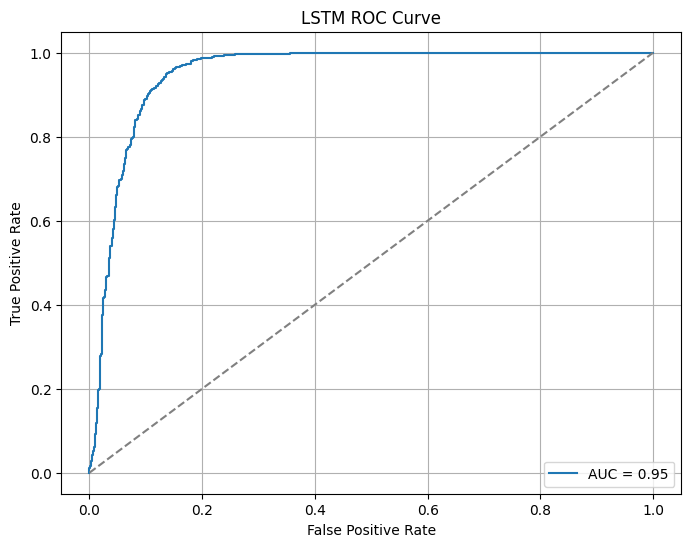

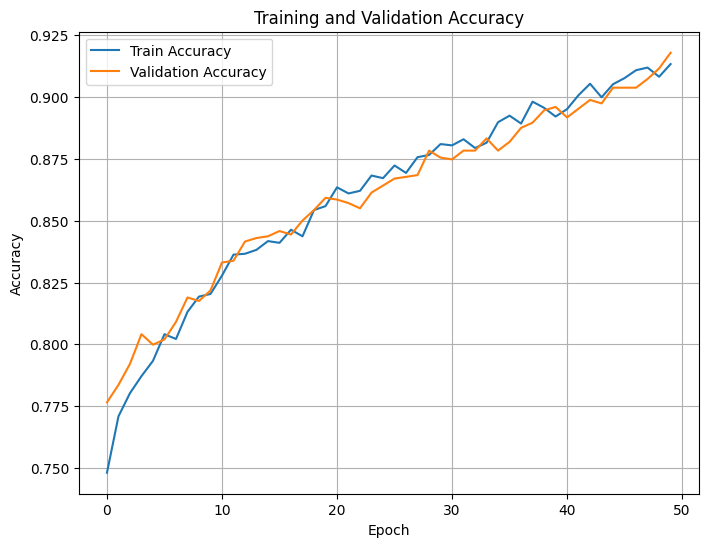

Total execution time: 70.80 seconds


In [ ]:
# Start timing
start_time = time.time()

# Step 5: Define the LSTM model
model_lstm = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),  # Explicit Input layer
    LSTM(64, activation='relu', return_sequences=True),          # First LSTM layer
    Dropout(0.2),
    LSTM(32, activation='relu'),                                 # Second LSTM layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')                               # Output layer for binary classification
])

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Step 6: Train the model
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=50, batch_size=32,
    validation_split=0.2, verbose=1
)

# Step 7: Predictions and performance metrics
y_prob_lstm = model_lstm.predict(X_test_lstm).ravel()
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

# Accuracy
accuracy_lstm = accuracy_score(y_test_lstm, y_pred_lstm)
print(f"Accuracy: {accuracy_lstm:.2f}")

# Classification report
unique_classes_lstm = np.unique(y_test_lstm)
target_names_lstm = ['Class ' + str(int(cls)) for cls in unique_classes_lstm]
report_lstm = classification_report(y_test_lstm, y_pred_lstm, target_names=target_names_lstm)
print("Classification Report:\n", report_lstm)

# AUC-ROC
auc_roc_lstm = roc_auc_score(y_test_lstm, y_prob_lstm)
print(f"AUC-ROC: {auc_roc_lstm:.2f}")

# ROC Curve
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test_lstm, y_prob_lstm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, label=f'AUC = {auc_roc_lstm:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Plot Training History
plt.figure(figsize=(8, 6))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

**10. Extended Long Short-Term Memory (xLSTM):**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define the XLSTM model
def create_xlstm_model(input_shape, lstm_units=[64, 32], dropout_rate=0.2, dense_units=32):
    """
    Create an extended LSTM (XLSTM) model with BatchNormalization and Dropout.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).
        lstm_units (list): List of LSTM layer units.
        dropout_rate (float): Dropout rate for regularization.
        dense_units (int): Number of dense layer units.

    Returns:
        keras.Model: Compiled XLSTM model.
    """
    inputs = Input(shape=input_shape)

    # Add LSTM layers with dropout and batch normalization
    x = inputs
    for units in lstm_units:
        x = LSTM(units, activation='relu', return_sequences=(units != lstm_units[-1]))(x)
        x = Dropout(dropout_rate)(x)
        x = BatchNormalization()(x)

    # Add a dense layer for further abstraction
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    # Output layer for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    # Create and compile the model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Train/Test assignments
X_train_xlstm = X_train.copy()
y_train_xlstm = y_train.copy()
X_test_xlstm = X_test.copy()
y_test_xlstm = y_test.copy()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 1, 17)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1, 64)               │          20,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,009 (136.75 KB)

 Trainable params: 34,753 (135.75 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6128 - loss: 0.7185 - val_accuracy: 0.5311 - val_loss: 0.6723
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7444 - loss: 0.5332 - val_accuracy: 0.7369 - val_loss: 0.5802
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7438 - loss: 0.5299 - val_accuracy: 0.7878 - val_loss: 0.4722
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7740 - loss: 0.4904 - val_accuracy: 0.7992 - val_loss: 0.4222
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7855 - loss: 0.4751 - val_accuracy: 0.8225 - val_loss: 0.4114
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7746 - loss: 0.4664 - val_accuracy: 0.8197 - val_loss: 0.4027
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7985 - loss: 0.4473 - val_accuracy: 0.8182 - val_loss: 0.3961
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7933 - loss: 0.4445 - val_accuracy: 

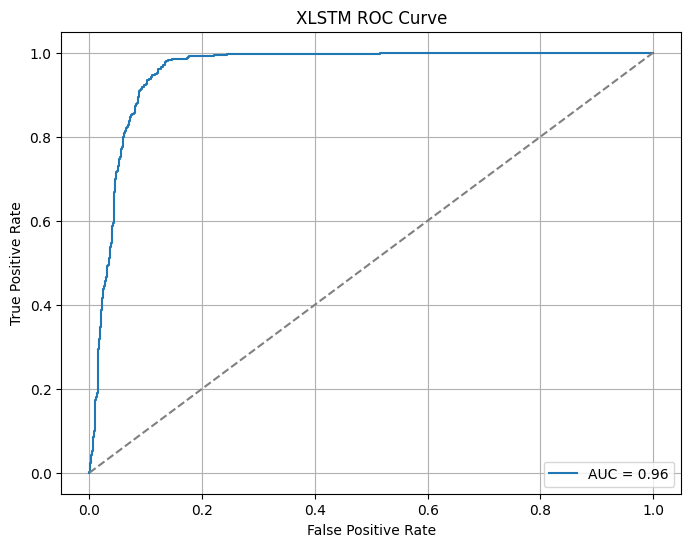

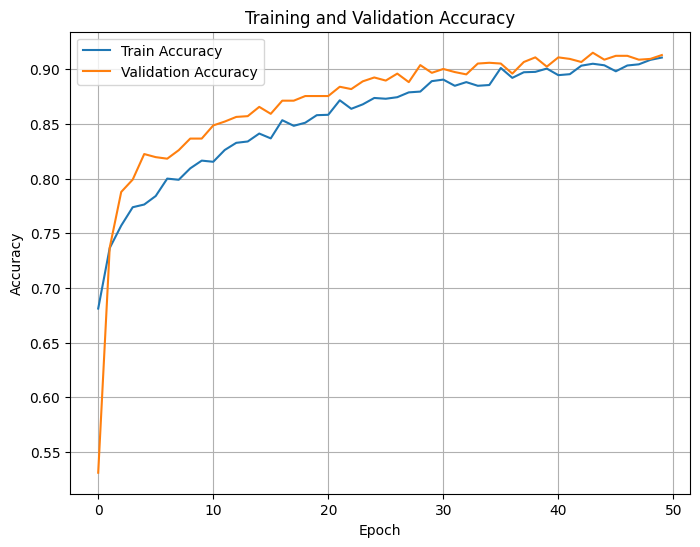

Total execution time: 96.03 seconds


In [ ]:
# Start timing
start_time = time.time()

# Ensure data is reshaped to 3D for LSTM (if not already)
if len(X_train_xlstm.shape) == 2:
    X_train_xlstm = X_train_xlstm.reshape((X_train_xlstm.shape[0], 1, X_train_xlstm.shape[1]))
    X_test_xlstm = X_test_xlstm.reshape((X_test_xlstm.shape[0], 1, X_test_xlstm.shape[1]))

# Create and summarize the model
input_shape = X_train_xlstm.shape[1:]
model_xlstm = create_xlstm_model(input_shape)
model_xlstm.summary()

# Train the model
history_xlstm = model_xlstm.fit(
    X_train_xlstm, y_train_xlstm,
    epochs=50, batch_size=32, validation_split=0.2, verbose=1
)

# Predictions and performance metrics
y_prob_xlstm = model_xlstm.predict(X_test_xlstm).ravel()
y_pred_xlstm = (y_prob_xlstm > 0.5).astype(int)

# Accuracy
accuracy_xlstm = accuracy_score(y_test_xlstm, y_pred_xlstm)
print(f"Accuracy: {accuracy_xlstm:.2f}")

# Classification report
unique_classes_xlstm = np.unique(y_test_xlstm)
target_names_xlstm = ['Class ' + str(int(cls)) for cls in unique_classes_xlstm]
report_xlstm = classification_report(y_test_xlstm, y_pred_xlstm, target_names=target_names_xlstm)
print("Classification Report:\n", report_xlstm)

# AUC-ROC
auc_roc_xlstm = roc_auc_score(y_test_xlstm, y_prob_xlstm)
print(f"AUC-ROC: {auc_roc_xlstm:.2f}")

# ROC Curve
fpr_xlstm, tpr_xlstm, thresholds_xlstm = roc_curve(y_test_xlstm, y_prob_xlstm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xlstm, tpr_xlstm, label=f'AUC = {auc_roc_xlstm:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XLSTM ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Training History
plt.figure(figsize=(8, 6))
plt.plot(history_xlstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_xlstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

**11. Transformer:**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten
)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Transformer block
def transformer_block(inputs, num_heads, ff_dim, dropout_rate):
    """
    Create a Transformer block.

    Args:
        inputs (tf.Tensor): Input tensor.
        num_heads (int): Number of attention heads.
        ff_dim (int): Feed-forward layer dimensionality.
        dropout_rate (float): Dropout rate.

    Returns:
        tf.Tensor: Output tensor.
    """
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-forward layer
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    return LayerNormalization(epsilon=1e-6)(attention_output + ff_output)

# Transformer model definition
def create_transformer_model(input_shape, num_heads=4, ff_dim=64, num_layers=2, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    x = inputs

    # Add multiple Transformer blocks
    for _ in range(num_layers):
        x = transformer_block(x, num_heads, ff_dim, dropout_rate)

    # Flatten the output tensor
    x = Flatten()(x)

    # Dense layers and final output
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation="sigmoid")(x)  # Binary classification

    # Compile the model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [ ]:
# Train/Test assignments
X_train_trans = X_train.copy()
y_train_trans = y_train.copy()
X_test_trans = X_test.copy()
y_test_trans = y_test.copy()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 1, 17)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 1, 17)          │          4,845 │ input_layer_9[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 1, 17)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 1, 17)          │              0 │ input_layer_9[0][0],   │
│                           │                        │                │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 1, 17)          │             34 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 1, 64)          │          1,152 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 1, 64)          │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 1, 17)          │          1,105 │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 1, 17)          │              0 │ layer_normalization_4… │
│                           │                        │                │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 1, 17)          │             34 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 1, 17)          │          4,845 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 1, 17)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 1, 17)          │              0 │ layer_normalization_5… │
│                           │                        │                │ dropout_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 1, 17)          │             34 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 1, 64)          │          1,152 │ layer_normalization_6… │
├──────────────────────

 Total params: 15,557 (60.77 KB)

 Trainable params: 15,557 (60.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6690 - loss: 0.6010 - val_accuracy: 0.7857 - val_loss: 0.4798
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7687 - loss: 0.5014 - val_accuracy: 0.8091 - val_loss: 0.4577
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7856 - loss: 0.4718 - val_accuracy: 0.8013 - val_loss: 0.4525
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7896 - loss: 0.4767 - val_accuracy: 0.7992 - val_loss: 0.4525
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8048 - loss: 0.4495 - val_accuracy: 0.8041 - val_loss: 0.4387
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8035 - loss: 0.4506 - val_accuracy: 0.8069 - val_loss: 0.4327
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8057 - loss: 0.4453 - val_accuracy: 0.8274 - val_loss: 0.4208
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8118 - loss: 0.4305 - val_accurac

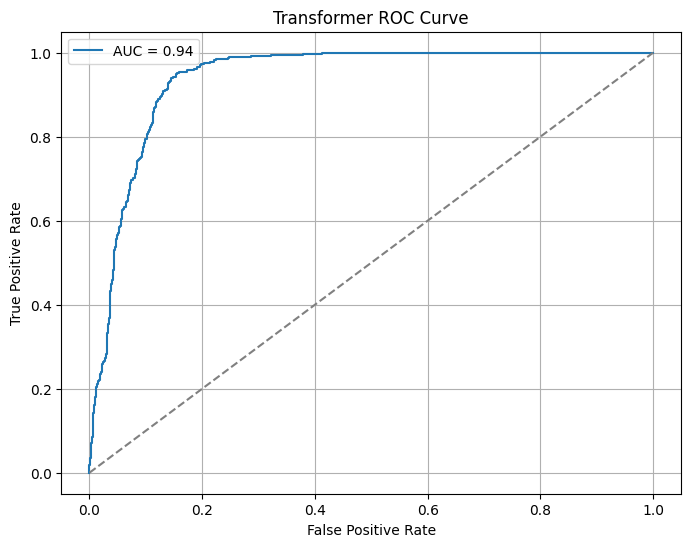

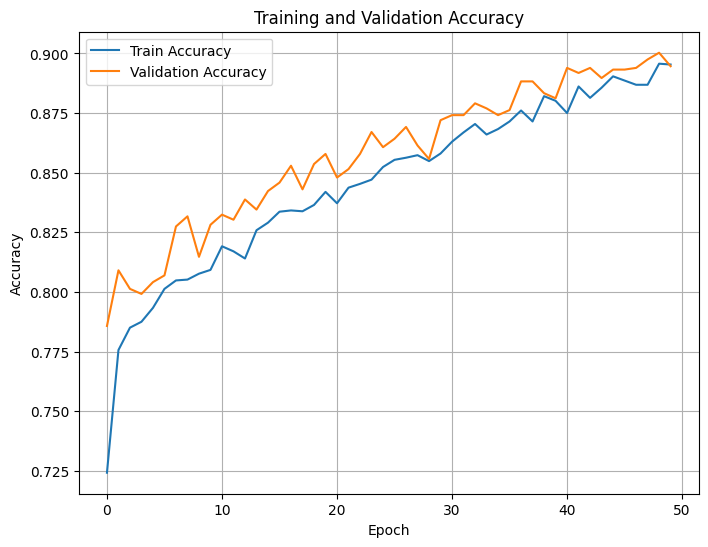

Total execution time: 143.64 seconds


In [ ]:
# Start timing
start_time = time.time()

# Ensure the data is reshaped to 3D for the Transformer
if len(X_train_trans.shape) == 2:
    X_train_trans = X_train_trans.reshape((X_train_trans.shape[0], 1, X_train_trans.shape[1]))
    X_test_trans = X_test_trans.reshape((X_test_trans.shape[0], 1, X_test_trans.shape[1]))

# Create and summarize the model
input_shape = X_train_trans.shape[1:]
model_trans = create_transformer_model(input_shape)
model_trans.summary()

# Train the model
history_trans = model_trans.fit(
    X_train_trans, y_train_trans,
    epochs=50, batch_size=32, validation_split=0.2, verbose=1
)

# Predictions and performance metrics
y_prob_trans = model_trans.predict(X_test_trans).ravel()
y_pred_trans = (y_prob_trans > 0.5).astype(int)

# Accuracy
accuracy_trans = accuracy_score(y_test_trans, y_pred_trans)
print(f"Accuracy: {accuracy_trans:.2f}")

# Classification report
unique_classes_trans = np.unique(y_test_trans)
target_names_trans = ['Class ' + str(int(cls)) for cls in unique_classes_trans]
report_trans = classification_report(y_test_trans, y_pred_trans, target_names=target_names_trans)
print("Classification Report:\n", report_trans)

# AUC-ROC
auc_roc_trans = roc_auc_score(y_test_trans, y_prob_trans)
print(f"AUC-ROC: {auc_roc_trans:.2f}")

# ROC Curve
fpr_trans, tpr_trans, thresholds_trans = roc_curve(y_test_trans, y_prob_trans)
plt.figure(figsize=(8, 6))
plt.plot(fpr_trans, tpr_trans, label=f'AUC = {auc_roc_trans:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Training History
plt.figure(figsize=(8, 6))
plt.plot(history_trans.history['accuracy'], label='Train Accuracy')
plt.plot(history_trans.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

**12. Transformer based - TabPFN:**

In [ ]:
pip install tabpfn

In [ ]:
from tabpfn import TabPFNClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Train/Test assignments
X_train_tabpfn = X_train.copy()
y_train_tabpfn = y_train.copy()
X_test_tabpfn = X_test.copy()
y_test_tabpfn = y_test.copy()

Original training data size: 7070 samples
Downsampled training data size: 1024 samples


/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:88: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.91      0.99      0.95       886
     Class 1       0.99      0.91      0.95       882

    accuracy                           0.95      1768
   macro avg       0.95      0.95      0.95      1768
weighted avg       0.95      0.95      0.95      1768

AUC-ROC: 0.98


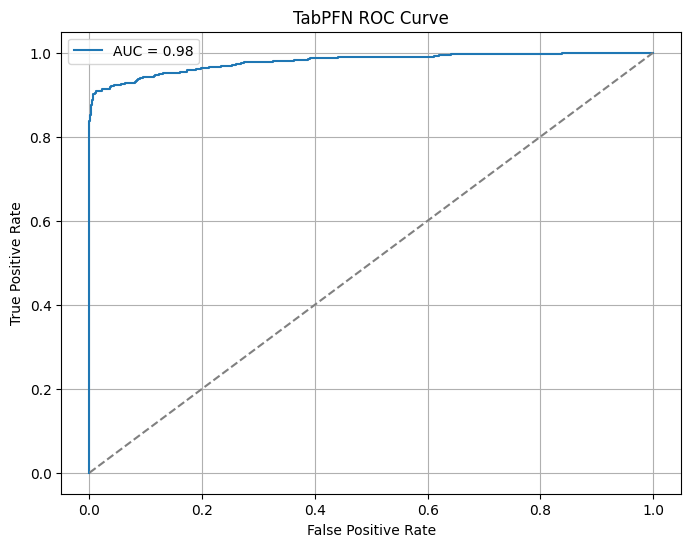

Total execution time: 959.20 seconds


In [ ]:
# Start timing
start_time = time.time()

# Check training data size
print(f"Original training data size: {X_train_tabpfn.shape[0]} samples")

# Downsample training data to 1024 samples if necessary
if X_train_tabpfn.shape[0] > 1024:
    X_train_tabpfn, y_train_tabpfn = resample(
        X_train_tabpfn, y_train_tabpfn,
        n_samples=1024, stratify=y_train_tabpfn, random_state=42
    )
    print(f"Downsampled training data size: {X_train_tabpfn.shape[0]} samples")

# Initialize TabPFN Classifier
model_tabpfn = TabPFNClassifier(device='cpu')  # Use 'cuda' for GPU acceleration

# Train the model
model_tabpfn.fit(X_train_tabpfn, y_train_tabpfn)

# Predictions and probabilities
y_pred_tabpfn = model_tabpfn.predict(X_test_tabpfn)
y_prob_tabpfn = model_tabpfn.predict_proba(X_test_tabpfn)[:, 1]

# Accuracy
accuracy_tabpfn = accuracy_score(y_test_tabpfn, y_pred_tabpfn)
print(f"Accuracy: {accuracy_tabpfn:.2f}")

# Classification report
unique_classes_tabpfn = np.unique(y_test_tabpfn)
target_names_tabpfn = ['Class ' + str(int(cls)) for cls in unique_classes_tabpfn]
report_tabpfn = classification_report(y_test_tabpfn, y_pred_tabpfn, target_names=target_names_tabpfn)
print("Classification Report:\n", report_tabpfn)

# AUC-ROC
auc_roc_tabpfn = roc_auc_score(y_test_tabpfn, y_prob_tabpfn)
print(f"AUC-ROC: {auc_roc_tabpfn:.2f}")

# ROC Curve
fpr_tabpfn, tpr_tabpfn, thresholds_tabpfn = roc_curve(y_test_tabpfn, y_prob_tabpfn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_tabpfn, tpr_tabpfn, label=f'AUC = {auc_roc_tabpfn:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TabPFN ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Stop timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")